In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import os
from os.path import join, exists, split
import sys

sys.path.append(f'{os.getcwd()}/../')
from gsn.perform_gsn import perform_gsn
from gsn.denoise_data import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import urllib.request

import traceback
import pdb

In [200]:
# get path to the directory to which GSN was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

# create directory for saving outputs from example 1
outputdir = join(homedir,'examples','example2outputs')

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example1 outputs:\n\t{outputdir}\n')

os.makedirs(outputdir,exist_ok=True)

directory to save example dataset:
	/home/jovyan/work/DropboxProjects/GSN/examples/data

directory to save example1 outputs:
	/home/jovyan/work/DropboxProjects/GSN/examples/example2outputs



In [126]:
# download example dataset from GSN OSF repository
datafn = join(datadir,'exampledata.mat')

# to save time, we'll skip the download if the example dataset already exists on disk
if not exists(datafn):

    print(f'Downloading example dataset and saving to:\n{datafn}')

    dataurl = 'https://osf.io/download/utfpq/'

    # download the .mat file to the specified directory
    urllib.request.urlretrieve(dataurl, datafn)

# load struct containing example dataset
X = sio.loadmat(datafn)


In [127]:
train_data = X['data'].copy()[:,::2]
test_data = X['data'].copy()[:,1::2]

nvox, ncond, ntrial = train_data.shape
print(nvox, ncond, ntrial)

100 100 3


In [128]:
# data contains 100 voxels x 200 conditions x 3 trials.
# The values are fMRI response amplitudes in percent signal change units.

# Perform GSN.
# We explicitly set the wantshrinkage flag to true.
results = perform_gsn(train_data.copy(), {'wantshrinkage': True})


Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.


/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


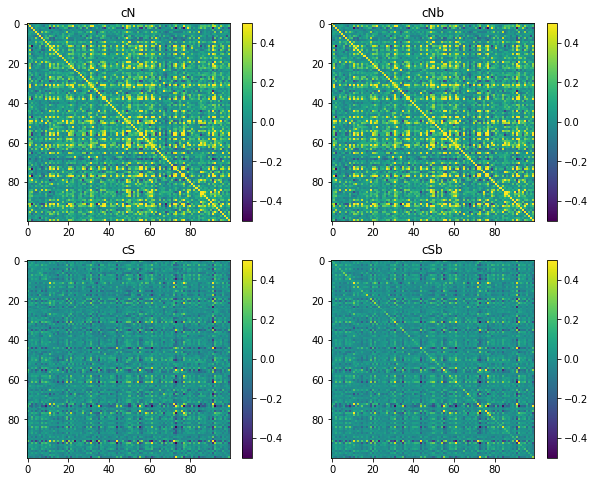

In [129]:
# Set range for color limits
rng = [-0.5, 0.5]

# Visualize the covariance estimates
plt.figure(figsize=(10, 8))

# Noise covariance estimate
plt.subplot(2, 2, 1)
plt.imshow(results['cN'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cN')
plt.axis('tight')

# Final noise covariance estimate
plt.subplot(2, 2, 2)
plt.imshow(results['cNb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cNb')
plt.axis('tight')

# Signal covariance estimate
plt.subplot(2, 2, 3)
plt.imshow(results['cS'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cS')
plt.axis('tight')

# Final signal covariance estimate
plt.subplot(2, 2, 4)
plt.imshow(results['cSb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cSb')
plt.axis('tight')

plt.show()

In [130]:
# We have several outputs in results:
# mnN is the mean of the noise distribution
# cN is the raw estimate of the covariance of the noise distribution 
# cNb is the final estimate of the covariance of the noise distribution
# mnS is the mean of the signal distribution
# cS is the raw estimate of the covariance of the signal distribution 
# cSb is the final estimate of the covariance of the signal distribution
# shrinklevelN is the shrinkage fraction used when estimating the noise distribution
# shrinklevelD is the shrinkage fraction used when estimating the data distribution
# ncsnr is the noise ceiling snr for each voxel (signal sd divided by noise sd)

In [131]:
train_data_ctv = train_data.copy().transpose(1,2,0)
test_data_ctv = test_data.copy().transpose(1,2,0)
print(train_data_ctv.shape)

(100, 3, 100)


In [191]:
bases = ['cS','cSb','cNb','naive PCA','random']

basis_eigenvectors = dict()
basis_eigenspectra = dict()

for basis in bases:

    if basis == 'random':
        eigenvectors = random_orthonormal_basis(nvox)
        eigenvalues = np.array([])
    else:
        if basis == 'naive PCA':
            train_data_mean = np.mean(train_data_ctv, axis = 1)
            train_data_mean = train_data_mean - np.mean(train_data_mean, axis = 0)
            cov = np.cov(train_data_mean.T)
        else:
            cov = results[basis]

        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        idx = np.flip(np.argsort(eigenvalues))
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:,idx]
        
    basis_eigenvectors[basis] = eigenvectors.copy()
    basis_eigenspectra[basis] = eigenvalues.copy()
    

In [192]:
def increase_fontsize(increment=2):
    """
    Increase the font size of all text elements in the current open figure by a specified increment.

    Parameters:
    increment (int, optional): The number of points by which to increase the font size. Default is 2.
    """
    fig = plt.gcf()  # Get the current figure
    
    # Iterate over all text elements in the figure (axes labels, titles, tick labels, etc.)
    for ax in fig.get_axes():
        # Increase font size for axis title, labels, and tick labels
        if ax.get_title():
            ax.title.set_fontsize(ax.title.get_fontsize() + increment)
        ax.xaxis.label.set_fontsize(ax.xaxis.label.get_fontsize() + increment)
        ax.yaxis.label.set_fontsize(ax.yaxis.label.get_fontsize() + increment)
        
        # Increase font size for tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(label.get_fontsize() + increment)
    
        # Increase font size for legend text, if any
        legend = ax.get_legend()
        if legend is not None:
            for text in legend.get_texts():
                text.set_fontsize(text.get_fontsize() + increment)

In [ ]:
def denoising_procedure(basis):
    
    threshold_per = 'population'
    denoising_V = basis_eigenvectors[basis].copy()
    thresholds = np.arange(nvox)
    match_profiles = False
    rescue = True

    denoised_test_data, tuning_corrs, denoiser, opt_threshold, ncsnrs, ncs = denoise_data(train_data_ctv.copy(), 
                                                                             test_data_ctv.copy(), 
                                                                             denoising_V, 
                                                                             thresholds, 
                                                                             threshold_per, 
                                                                             match_profiles,
                                                                             rescue)
    
    fig = plt.figure(figsize=(30,27))
    
    
    plt.subplot(331)
    plt.plot(basis_eigenspectra[basis],linewidth=3,color='k')
    plt.title(f'eigenspectrum of {basis} basis')
    plt.xlabel('dimension')
    plt.ylabel('variance')
    
    plot_basis_dim_ncsnrs(train_data_ctv, denoising_V, basis, opt_threshold, subplots = (332,333))

    ncsnr_init = ncsnrs[0]
    ncsnr_final = ncsnrs[-1]
    
    nc_init = ncs[0]
    nc_final = ncs[-1]
    
    plt.subplot(334)
    plt.imshow(test_data_ctv.mean(1),aspect='auto',interpolation='none',clim=(-4,4),cmap='RdBu_r')
    plt.colorbar()
    plt.title(f'basis: {basis}\nraw')
    plt.xlabel('voxels')
    plt.ylabel('conditions')
    
    plt.subplot(335)
    plt.imshow(denoised_test_data.mean(1),aspect='auto',interpolation='none',clim=(-4,4),cmap='RdBu_r')
    plt.colorbar()
    plt.title(f'basis: {basis}\ndenoised')
    plt.xlabel('voxels')
    plt.ylabel('conditions')
    
    plt.subplot(336)
    plt.imshow(denoiser,aspect='auto',interpolation='none',clim=(-0.5,0.5),cmap='RdBu_r')
    plt.colorbar()
    plt.xlabel('voxels')
    plt.ylabel('voxels')
    plt.title('optimal denoising matrix')
    
    plt.subplot(337)
    plt.imshow(tuning_corrs.mean(1),aspect='auto',interpolation='none',clim=(0,0.5))
    plt.yticks(np.arange(len(thresholds))[::5], np.array(thresholds)[::5])
    if threshold_per == 'population':
        plt.plot([0, nvox], [opt_threshold.mean(), opt_threshold.mean()],'r--',linewidth=2)
    elif threshold_per == 'unit':
        plt.plot(np.arange(nvox), opt_threshold, 'ro-',linewidth=1)
    plt.colorbar()
    plt.xlabel('voxels')
    plt.ylabel('PC exclusion threshold')
    plt.title(f'{basis}: split-half tuning correlations per voxel/threshold')

    plt.subplot(338)
    plt.scatter(ncsnr_init, ncsnr_final, 10)
    plt.xlabel(f'init mean ncsnr:\n {round(np.nanmean(ncsnr_init),3)}')
    plt.ylabel(f'denoised mean ncsnr:\n{round(np.nanmean(ncsnr_final),3)}')
    plt.plot([0,1.5],[0,1.5],'r--')
    if threshold_per == 'population':
        plt.title(f'{basis} change in nc\noptimal PC threshold = {opt_threshold}')
    else:
        plt.title(f'{basis} change in nc\noptimal PC threshold = {opt_threshold.mean()}')

    plt.subplot(339)
    plt.scatter(nc_init, nc_final, 10)
    plt.xlabel(f'init mean nc:\n{round(np.nanmean(nc_init),3)}')
    plt.ylabel(f'denoised mean nc:\n{round(np.nanmean(nc_final),3)}')
    plt.plot([0,100],[0,100],'r--')
    if threshold_per == 'population':
        plt.title(f'{basis} change in nc\noptimal PC threshold = {opt_threshold}')
    else:
        plt.title(f'{basis} change in nc\noptimal PC threshold = {opt_threshold.mean()}')
    
    increase_fontsize(8)
    plt.tight_layout()
    plt.savefig(f'{outputdir}/{basis}_diagnostics.pdf')
    plt.show()
    
    out = {'data_out':  denoised_test_data,
           'corrs':     tuning_corrs,
           'denoiser':  denoiser,
           'thresh':    opt_threshold,
           'ncsnrs':    [ncsnr_init, ncsnr_final],
           'ncs':       [nc_init, nc_final]}
    
    return out


In [ ]:
for basis in ['cSb','naive PCA',]:
    out = denoising_procedure(basis)